In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt" , "r").read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))

stoi = {c : idx + 1 for idx , c in enumerate(chars)}
stoi['.'] = 0
itos = {idx : c for c , idx in stoi.items()}

In [4]:
vocab_size = len(stoi)

In [5]:
# Dataset Preperation
block_size = 3

X = []
y = []


for word in words:
    context = [0] * block_size
    word = list(word) + ['.']
    
    for ch in word:
        idx = stoi[ch]
        
        X.append(context)
        y.append(idx)
        
        context = context[1:] + [idx]
    
n1 = int(0.8 * len(X))
n2 = int(0.9 * len(X))

X_train = torch.tensor(X[:n1])
y_train = torch.tensor(y[:n1])
X_val = torch.tensor(X[n1:n2])
y_val = torch.tensor(y[n1:n2])
X_test = torch.tensor(X[n2:])
y_test = torch.tensor(y[n2:])

In [6]:
g = torch.Generator().manual_seed(1514323)

class Linear:
    def __init__(self , fan_in , fan_out , bias=True):
        self.weight = torch.randn((fan_in , fan_out) , generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self , x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNormalization:
    def __init__(self , dim , eps=1e-5 , momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # Parameters training with backprops
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # Buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
    
    def __call__(self , x: torch.Tensor):
        if self.training:
            xmean = x.mean(0 , keepdim=True)
            xvar = x.var(0 , keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out
    
    def parameters(self):
        return [self.gamma , self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embed = 10
n_hidden = 100

C = torch.randn((vocab_size , n_embed) , generator=g)

In [7]:
layers = [
    Linear(block_size * n_embed , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(),
    Linear(n_hidden , n_hidden , bias=False) , BatchNormalization(n_hidden) , Tanh(),
    Linear(n_hidden , vocab_size , bias=False) , BatchNormalization(vocab_size)
]

with torch.no_grad():
    if isinstance(layers[-1] , BatchNormalization):     
        layers[-1].gamma *= 0.1 # Make it less confident
    
    for layer in layers[:-1]:
        if isinstance(layer , Linear):
            layer.weight *= 5/3 # Gain
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum([p.nelement() for p in parameters]))
for p in parameters:
    p.requires_grad = True

47024


In [8]:
# Training Data
steps = 100000
batch_size = 32

for step in range(steps):
    idxs = torch.randint(len(X_train) , (batch_size,))
    
    xb = X_train[idxs]
    yb = y_train[idxs]
    
    # Forward Pass
    x = C[xb].reshape(-1 , n_embed * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x , yb)
    
    # Backpass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # Gradient Update
    lr = 0.1 if step < 50000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Stats
    if step % 1000 == 0:
        print(f"{step} / {steps} : {loss:.4f}")

0 / 100000 : 3.3242
1000 / 100000 : 2.1485
2000 / 100000 : 2.1467
3000 / 100000 : 2.7200
4000 / 100000 : 1.9135
5000 / 100000 : 2.0645
6000 / 100000 : 2.5071
7000 / 100000 : 2.2263
8000 / 100000 : 2.0369
9000 / 100000 : 2.3002
10000 / 100000 : 2.2817
11000 / 100000 : 2.0287
12000 / 100000 : 1.9575
13000 / 100000 : 1.8898
14000 / 100000 : 1.9216
15000 / 100000 : 1.7803
16000 / 100000 : 2.0734
17000 / 100000 : 2.3695
18000 / 100000 : 2.5779
19000 / 100000 : 2.0261
20000 / 100000 : 2.1125
21000 / 100000 : 2.4320


KeyboardInterrupt: 

Layer 2 (Tanh): mean: 0.0055 , std: 0.6253 saturated: 3.34%


Layer 5 (Tanh): mean: -0.0018 , std: 0.6284 saturated: 3.06%
Layer 8 (Tanh): mean: -0.0034 , std: 0.6322 saturated: 2.50%
Layer 11 (Tanh): mean: 0.0066 , std: 0.6361 saturated: 2.53%
Layer 14 (Tanh): mean: -0.0003 , std: 0.6320 saturated: 2.75%


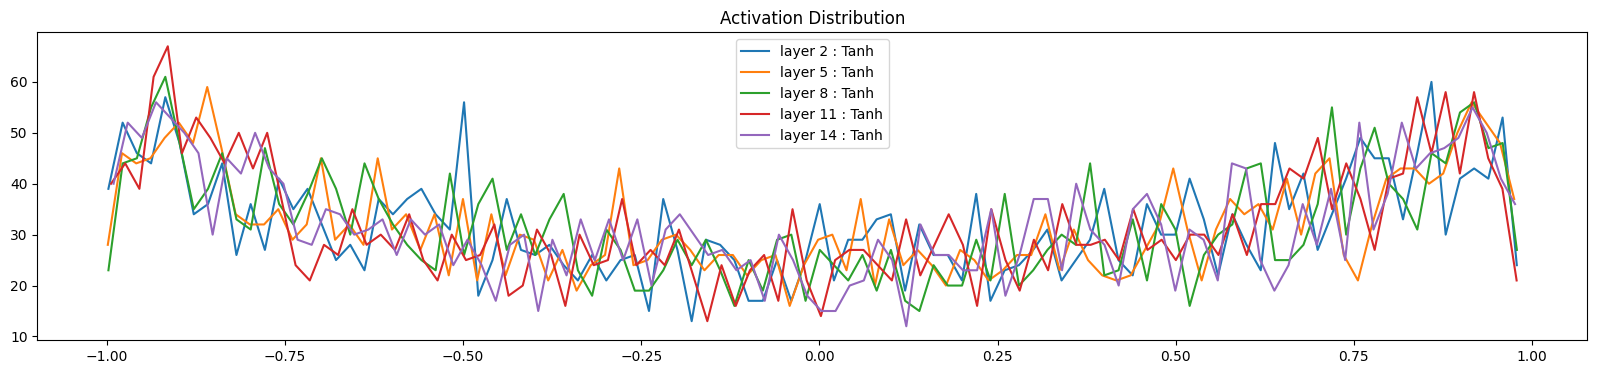

In [67]:
# Visualize Histograms
plt.figure(figsize=(20 ,4))
legends = []

for i , layer in enumerate(layers):
    if isinstance(layer , Tanh):
        t = layer.out
        hy , hx = torch.histogram(t)
        plt.plot(hx[:-1].detach() , hy.detach())
        legends.append(f"layer {i} : {layer.__class__.__name__}")
        print(f"Layer {i} ({layer.__class__.__name__}): mean: {t.mean():.4f} , std: {t.std():.4f} saturated: {((t.abs() > 0.97).float().mean() * 100):.2f}%")

plt.legend(legends)
plt.title("Activation Distribution")
plt.show()

Layer 0 (Linear): mean: -0.0000 , std: 0.0063
Layer 3 (Linear): mean: -0.0000 , std: 0.0082
Layer 6 (Linear): mean: 0.0000 , std: 0.0070
Layer 9 (Linear): mean: 0.0000 , std: 0.0059
Layer 12 (Linear): mean: 0.0000 , std: 0.0052
Layer 15 (Linear): mean: 0.0000 , std: 0.0083


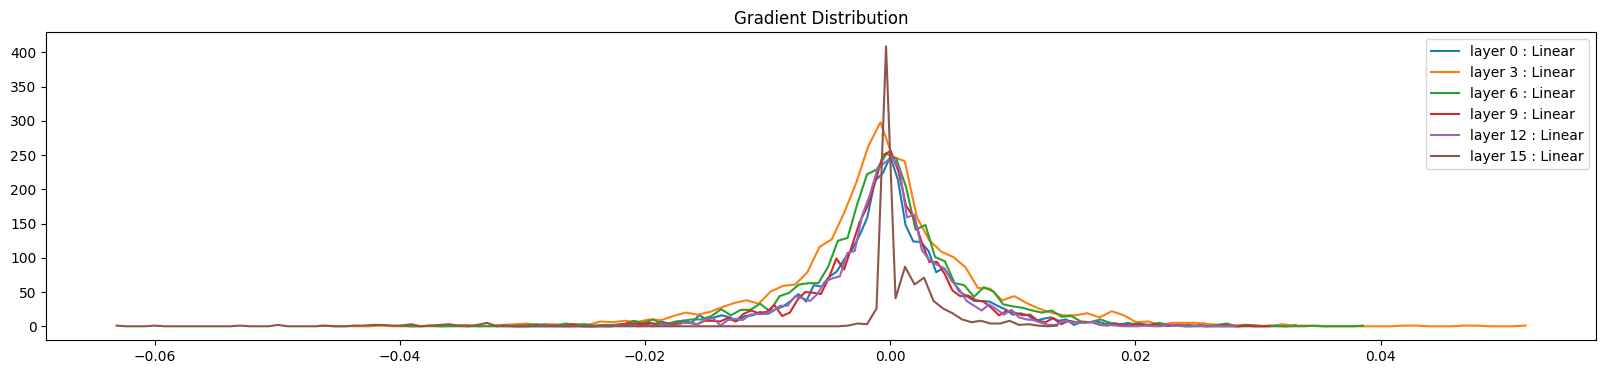

In [68]:
# Visualize Histograms
plt.figure(figsize=(20 ,4))
legends = []

for i , layer in enumerate(layers):
    if isinstance(layer , Linear):
        t = layer.out.grad
        hy , hx = torch.histogram(t)
        plt.plot(hx[:-1].detach() , hy.detach())
        legends.append(f"layer {i} : {layer.__class__.__name__}")
        print(f"Layer {i} ({layer.__class__.__name__}): mean: {t.mean():.4f} , std: {t.std():.4f}")

plt.legend(legends)
plt.title("Gradient Distribution")
plt.show()

In [9]:
for layer in layers:
    if isinstance(layer , BatchNormalization):
        layer.training = False

# Train Loss    
x = C[X_train]
x = x.view(x.shape[0] , -1)        
for layer in layers:
    x = layer(x)
loss = F.cross_entropy(x , y_train)
print(f"Train Loss : {loss}")

# Test Loss    
x = C[X_test]
x = x.view(x.shape[0] , -1)
for layer in layers:
    if isinstance(layer , BatchNormalization):
        layer.training = False
        
for layer in layers:
    x = layer(x)
loss = F.cross_entropy(x , y_test)
print(f"Test Loss : {loss}")

Train Loss : 2.112699508666992
Test Loss : 2.408294439315796


In [14]:
g = torch.Generator().manual_seed(141)

for _ in range(20):
    
    # context = [0] * block_size
    context = [0 , stoi['k'] , stoi['h']]
    out = ['k','h'] 
    while True:
        # Forward Passing
        x = C[context].reshape(-1 , n_embed * block_size)
        for layer in layers:
            x = layer(x)
        probx = F.softmax(x , dim=1)
        
        ix = torch.multinomial(probx , num_samples=1 , generator=g).item()        
        if ix == 0:
            break
        
        context = context[1:] + [ix]
        out.append(itos[ix])
    
    print(''.join(out))

khallie
khoneyla
kholeselihabelle
khaliann
khalix
khalona
khadnayellomet
khair
khia
khreen
khiko
khelber
khaverson
khylani
khilin
khato
khyley
khillia
khya
khorner
